# Credit Scoring

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,f1_score,log_loss,\
classification_report, roc_curve

import warnings
warnings.filterwarnings("ignore");

RAND = 10

# 1 Data Import

**Field Descriptions**

- client_id - client ID
- education - level of education
- sex - gender of the borrower
- age - the age of the borrower
- car - car availability flag
- car_type - flag of a foreign car
- decline_app_cnt - the number of rejected past applications
- good_work - flag for having a “good” job
- bki_request_cnt - number of requests in BKI
- home_address - home address categorizer
- work_address - work address categorizer
- income - the borrower's income
- foreign_passport - availability of a foreign passport
- sna - connection of the borrower with the bank's clients
- first_time - the limitation of the availability of information about the borrower
- score_bki - scoring score based on data from the BKI
- region_rating - region rating
- app_date - date of application submission
- default - the default flag on the loan

In [19]:
df = pd.read_csv('train.csv')
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1


In [20]:
print(f'Train size = {df.shape}')

Train size = (73799, 19)


In [21]:
df.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

let's check the percentage of omissions in the education field

In [23]:
df.education.isna().sum() / df.shape[0]*100

0.41599479667746175

In [24]:
# Checking unique education

df.education.unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD', nan], dtype=object)

- SCH - school
- GRD - Graduate School

- UGR - undergraduates, undergraduates

- PGR - Postgraduate student

- ACD - academician?

In [25]:
# We use Mode() to get the most common value to fill na fields
ed_mode = df.education.mode()[0]
df.education = df.education.fillna(ed_mode)

In [26]:
ed_mode

'SCH'

Let's translate the signs into a categorical form, where they are set as category values by condition

In [27]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


In [28]:
df.education.shape

(73799,)

In [16]:
df.nunique()

client_id           73799
app_date              120
education               5
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
score_bki           69096
bki_request_cnt        38
region_rating           7
home_address            3
work_address            3
income                966
sna                     4
first_time              4
foreign_passport        2
default                 2
dtype: int64

In [29]:
df.home_address.unique()

array([1, 2, 3])

In [30]:
df[['home_address','work_address']] = df[['home_address', 'work_address']].astype(object)

In [31]:
df.describe(include= object)

,app_date,education,sex,car,car_type,home_address,work_address,foreign_passport
count,73799,73799,73799,73799,73799,73799,73799,73799
unique,120,5,2,2,2,3,3,2
top,18MAR2014,SCH,F,N,N,2,3,N
freq,1018,39167,41562,49832,59791,39956,44959,62733


# Exploratory data analysis

**Hypotheses:**

- The age of the "good" borrowers is greater than that of the "bad" ones (the age distribution depending on the default flag is shifted up when default=0)
- The level of education depends on the age, which also affects the repayment of the loan, also people with higher education are more likely to be "good" borrowers
- With good_work = 0, the risk of non-repayment of the loan increases (default flag)
- The income of "good" borrowers is greater than that of "bad" ones (income distribution depending on the default flag is shifted up when default=0)
- score_bki is directly related to default, the smaller it is, the higher the client's probability of paying the loan to the bank

## Target

First need to find out the target variable

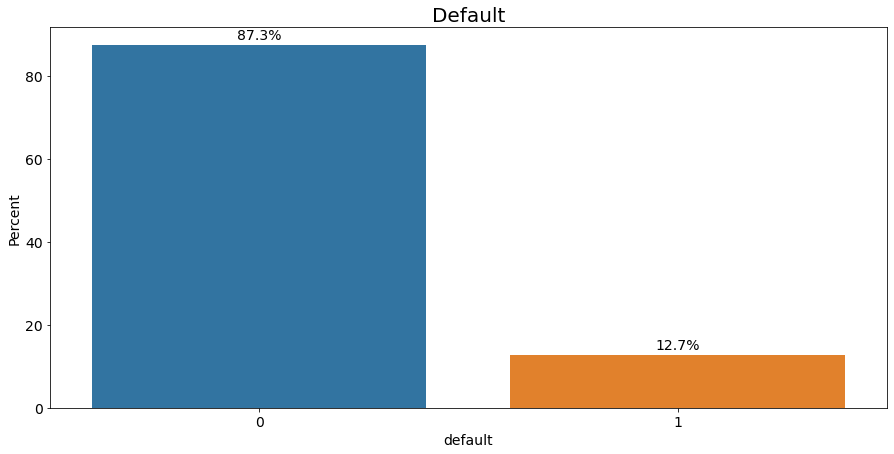

In [32]:
# rationing for the size of the dataset
norm_target = (df
               .default
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='index', y='percent', data=norm_target)

# Output of values above graphs - annotate()
# In the loop, we look at each column of the graph and mark the values on it

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # text
                (p.get_x() + p.get_width() / 2., p.get_height()),  # coordinate xy
                ha='center', # centering
                va='center',
                xytext=(0, 10),
                textcoords='offset points', # the offset point relative to the coordinate
                fontsize=14)

plt.title('Default', fontsize=20)

plt.xlabel('default', fontsize=14)
plt.ylabel('Percent', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

There is an imbalance of classes in the dataset, this should be taken into account when training the model

## Age

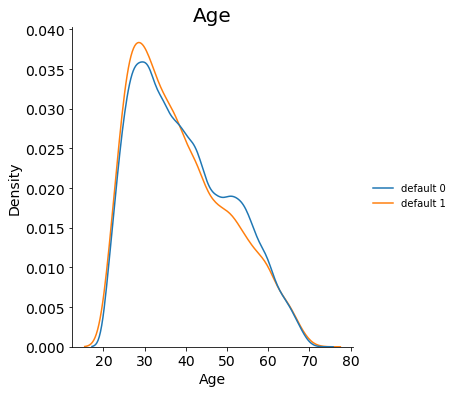

In [33]:
sns.displot(
    {
        "default 0": df[df.default ==0 ].age,
        "default 1": df[df.default == 1].age
    },
    kind="kde",
    common_norm=False # independent normalization of each subset
)

plt.title("Age", fontsize = 20)
plt.xlabel("Age", fontsize = 14)
plt.ylabel("Density", fontsize = 14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [34]:
df.groupby("default")['age'].median()

default
0    38.0
1    36.0
Name: age, dtype: float64

In [35]:
df.groupby("default")['age'].mean()

default
0    39.390504
1    38.525395
Name: age, dtype: float64

In [36]:
df.groupby("default")["age"].apply(lambda x: x.value_counts().index[0]).reset_index()

,default,age
0,0,31
1,1,26


## Education

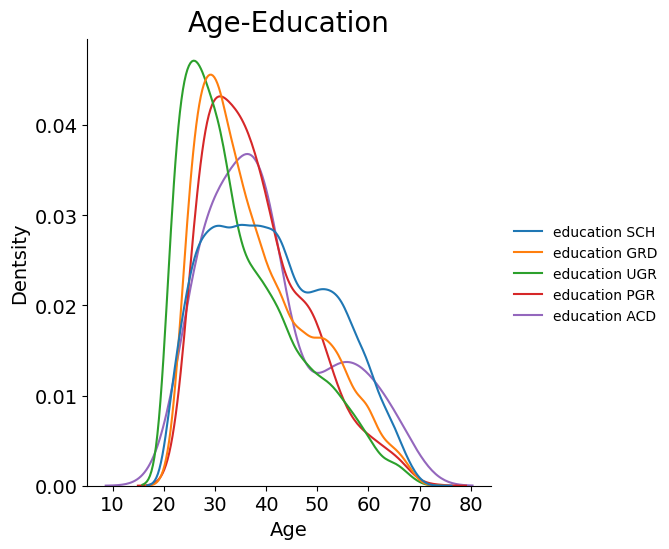

In [88]:
sns.displot(
    {
        "education SCH": df[df.education == 'SCH'].age,
        "education GRD": df[df.education == 'GRD'].age,
        "education UGR": df[df.education == 'UGR'].age,
        "education PGR": df[df.education == 'PGR'].age,
        "education ACD": df[df.education == 'ACD'].age,
    },
    kind="kde",
    common_norm=False
)

plt.title('Age-Education', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

If we take the formation of SCH (possibly another interpretation), then the age is shifted in a big way, compared with the same UGR. For ACD (academician), the age distribution is typically shifted to the left, if we compare it with PGR (aspirate), which is understandable in principle. The youngest are UGR, there is an assumption that to a greater extent they will be "bad" borrowers.

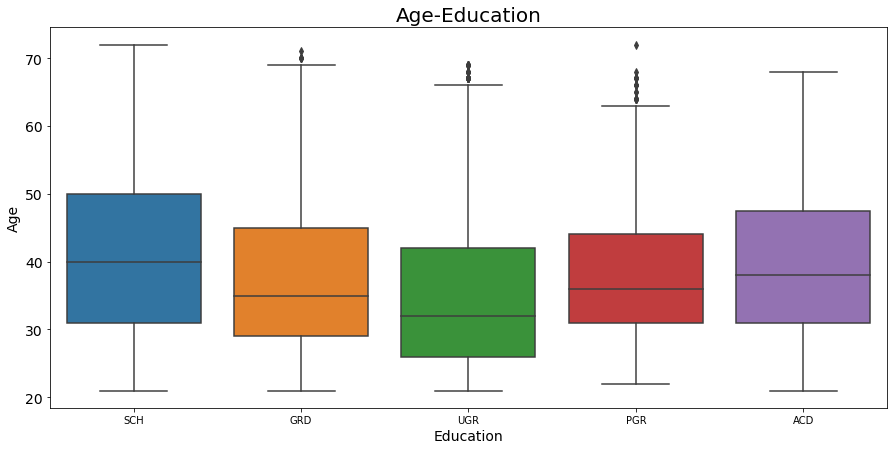

In [37]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='education', y='age', data=df)

plt.title('Age-Education', fontsize=20)
plt.ylabel('Age', fontsize=14)
plt.xlabel('Education', fontsize=14)


plt.yticks(fontsize=14);

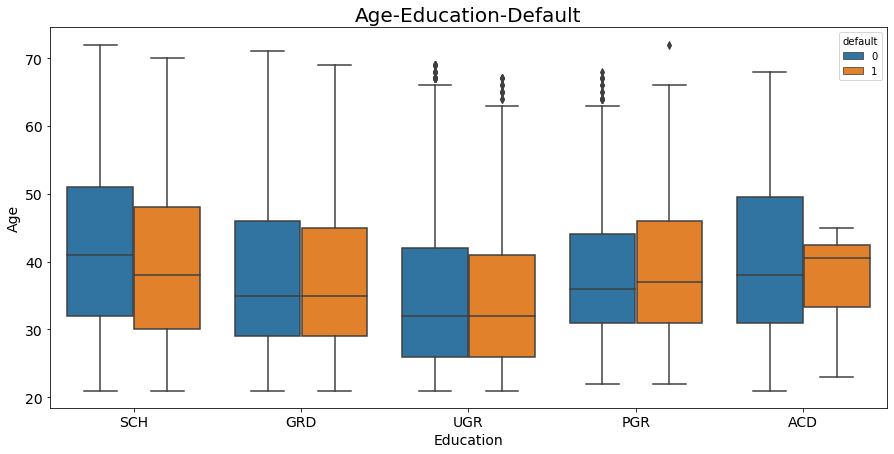

In [41]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='education', y='age', hue='default', data=df)

plt.title('Age-Education-Default', fontsize=20)
plt.ylabel('Age', fontsize=14)
plt.xlabel('Education', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Interestingly, if we take the education level of PGR and ACD, then the average age of "bad" borrowers is higher than that of "good" ones, but the spread of values for both is also high. Perhaps if we take some age limit, for example, from 30 to 50 years, then within this group this indicator will not greatly affect the full repayment of the loan.

In [42]:
df.groupby('education')['age'].median()

education
ACD    38.0
GRD    35.0
PGR    36.0
SCH    40.0
UGR    32.0
Name: age, dtype: float64

In [44]:
educ_def = (df.groupby(['default'])['education']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('education'))
educ_def

,default,education,percentage
4,0,ACD,0.288699
9,1,ACD,0.085361
1,0,GRD,32.998588
6,1,GRD,22.460521
3,0,PGR,1.825322
8,1,PGR,0.864277
0,0,SCH,51.655362
5,1,SCH,62.814767
2,0,UGR,13.232030
7,1,UGR,13.775075


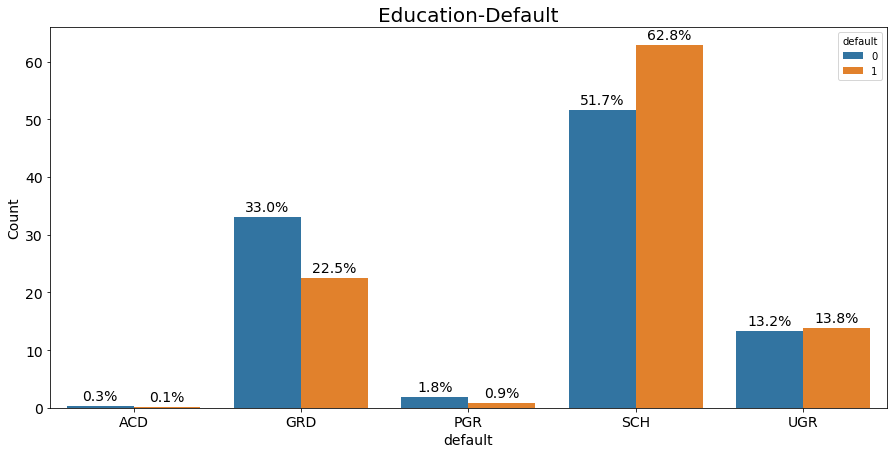

In [45]:
plt.figure(figsize=(15, 7))

educ_def = (df.groupby(['default'])['education']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('education'))

ax = sns.barplot(x="education", y="percentage", hue="default", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # text
                (p.get_x() + p.get_width() / 2., p.get_height()),  # xy coordinate
                ha='center',  # centering
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  #  offset point relative to the coordinate
                fontsize=14)

plt.title('Education-Default', fontsize=20)
plt.ylabel('Count', fontsize=14)
plt.xlabel('default', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Similarly, we see that the percentage of unscrupulous borrowers is higher with the level of education of SCH, for UGR the difference is not significant. Rather, in this case, it is not the age itself that affects, but the level of education. It can also be noted that to some extent GRD'S are more stable in terms of payments.

## Corr

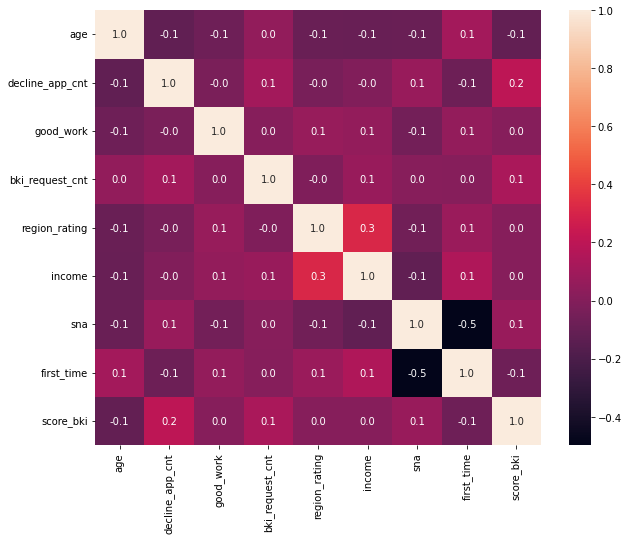

In [46]:
num_cols = ['age', 'decline_app_cnt', 'good_work', 'bki_request_cnt', 'region_rating', 'income', 'sna', 'first_time', 'score_bki']

plt.figure(figsize = (10, 8))
sns.heatmap(df[num_cols].corr(method = 'spearman'), annot=True, fmt='.1f');

## Income

(array([0.0e+00, 5.0e-06, 1.0e-05, 1.5e-05, 2.0e-05, 2.5e-05, 3.0e-05]),
 [Text(0, 0.0, '0.0'),
  Text(0, 4.9999999999999996e-06, '0.5'),
  Text(0, 9.999999999999999e-06, '1.0'),
  Text(0, 1.4999999999999999e-05, '1.5'),
  Text(0, 1.9999999999999998e-05, '2.0'),
  Text(0, 2.4999999999999998e-05, '2.5'),
  Text(0, 2.9999999999999997e-05, '3.0')])

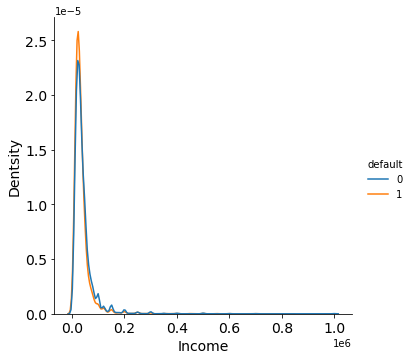

In [48]:
sns.displot(df, x='income', hue='default', kind='kde', common_norm = False)

plt.xlabel('Income', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-200000.,       0.,  200000.,  400000.,  600000.,  800000.,
        1000000., 1200000.]),
 [Text(0, -200000.0, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 200000.0, '0.2'),
  Text(0, 400000.0, '0.4'),
  Text(0, 600000.0, '0.6'),
  Text(0, 800000.0, '0.8'),
  Text(0, 1000000.0, '1.0'),
  Text(0, 1200000.0, '1.2')])

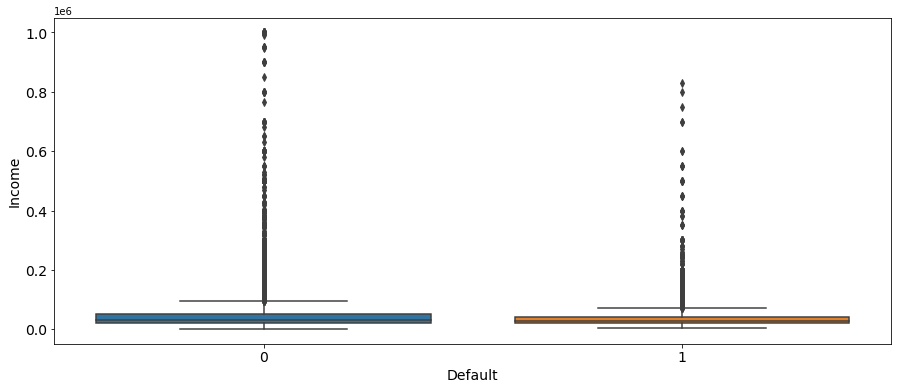

In [49]:
plt.figure(figsize=(15,6))

sns.boxplot(x='default', y= 'income', data=df)

plt.xlabel('Default', fontsize=14)
plt.ylabel('Income', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [50]:
df.groupby('default')['income'].mean()

default
0    41799.713288
1    36288.113316
Name: income, dtype: float64

In [51]:
df.groupby('default')['income'].median()

default
0    30000.0
1    28000.0
Name: income, dtype: float64

In [52]:
df_income = df.copy()
df_income.income = np.log(df.income+1)
df_income

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,9.798183,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,9.852247,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,10.308986,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,9.210440,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,10.308986,1,4,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,9.741027,4,4,N,0
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,11.156265,1,4,N,0
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,10.714440,2,2,N,0
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,9.472782,2,3,N,1


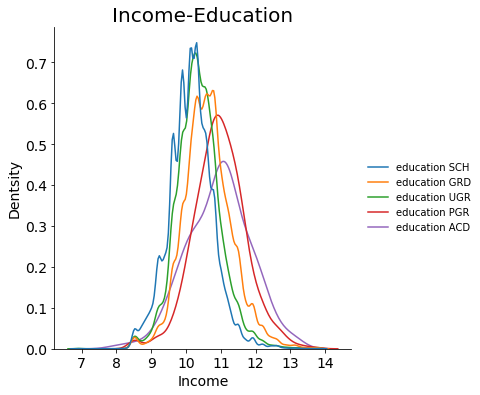

In [53]:
sns.displot(
    {
        "education SCH": df_income[df_income.education == 'SCH'].income,
        "education GRD": df_income[df_income.education == 'GRD'].income,
        "education UGR": df_income[df_income.education == 'UGR'].income,
        "education PGR": df_income[df_income.education == 'PGR'].income,
        "education ACD": df_income[df_income.education == 'ACD'].income,
    },
    kind="kde",
    common_norm=False
)

plt.title('Income-Education', fontsize=20)
plt.xlabel('Income', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

# Feature engineering

In [55]:
df.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

In [56]:
num_cols = ['age', 'decline_app_cnt', 'score_bki',
            'bki_request_cnt', 'income', 'first_time','region_rating']

In [70]:
numeric_features = df[num_cols]
numeric_features


,age,decline_app_cnt,score_bki,bki_request_cnt,income,first_time,region_rating
0,62,0,-2.008753,1,18000,1,50
1,59,0,-1.532276,3,19000,1,50
2,25,2,-1.408142,1,30000,4,80
3,53,0,-2.057471,2,10000,3,50
4,48,0,-1.244723,1,30000,4,60
...,...,...,...,...,...,...,...
73794,45,0,-1.792064,3,17000,4,50
73795,41,0,-2.058029,1,70000,4,50
73796,31,0,-1.512635,4,45000,2,80
73797,29,0,-1.479334,3,13000,3,50


In [71]:
numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

numeric_features

,level_0,Features,Value
0,0,age,62.000000
1,0,decline_app_cnt,0.000000
2,0,score_bki,-2.008753
3,0,bki_request_cnt,1.000000
4,0,income,18000.000000
...,...,...,...
516588,73798,score_bki,-1.764711
516589,73798,bki_request_cnt,2.000000
516590,73798,income,25000.000000
516591,73798,first_time,3.000000


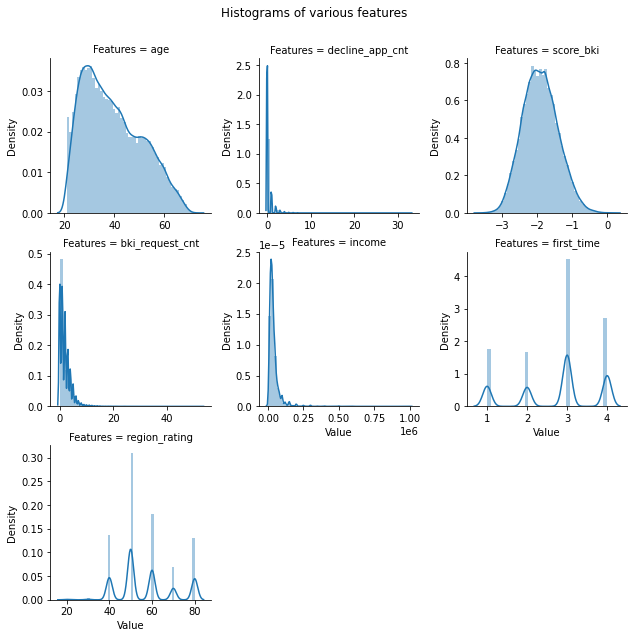

In [73]:

ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=0.9)
plt.suptitle("Histograms of various features");

trying to normalize data with log function

In [74]:
for i in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    df[i] = np.log(df[i]+1)

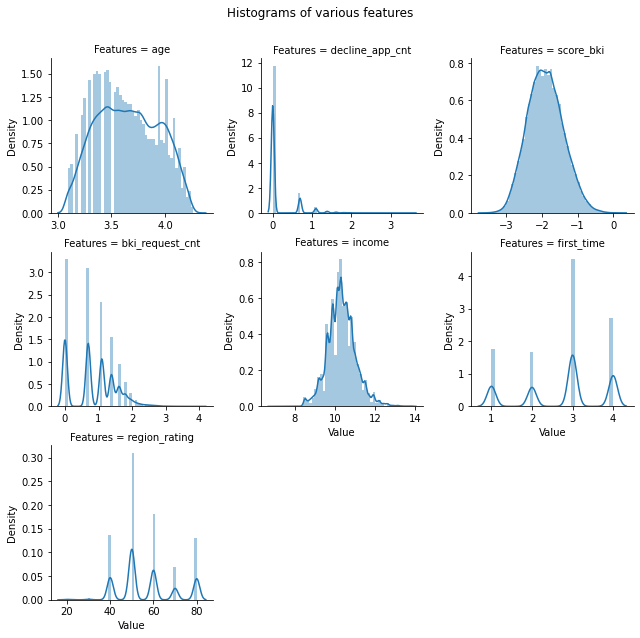

In [75]:
numeric_features = df[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=0.9)
plt.suptitle("Histograms of various features");

In [79]:
# New feature - month

df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')
df['month'] = df['app_date'].dt.month.astype(object)

df.drop(['app_date'], axis= 1, inplace= True)

df

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,month
0,25905,SCH,M,4.143135,Y,Y,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,N,0,2
1,63161,SCH,F,4.094345,N,N,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,N,0,3
2,25887,SCH,M,3.258097,Y,N,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,Y,0,2
3,16222,SCH,F,3.988984,N,N,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,N,0,1
4,101655,GRD,M,3.891820,N,N,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,Y,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,GRD,F,3.828641,N,N,0.000000,0,-1.792064,1.386294,50,1,2,9.741027,4,4,N,0,3
73795,76821,SCH,M,3.737670,Y,Y,0.000000,0,-2.058029,0.693147,50,2,2,11.156265,1,4,N,0,3
73796,103695,SCH,M,3.465736,N,N,0.000000,0,-1.512635,1.609438,80,2,3,10.714440,2,2,N,0,4
73797,861,SCH,F,3.401197,N,N,0.000000,1,-1.479334,1.386294,50,1,3,9.472782,2,3,N,1,1


In [80]:
# Average income based on the region's rating

mean_inc_reg = df.groupby('region_rating')['income'].median().to_dict()
mean_inc_reg

{20: 10.043292972227004,
 30: 9.975584260236154,
 40: 10.12667110305036,
 50: 10.12667110305036,
 60: 10.308985993422082,
 70: 10.645448706505872,
 80: 10.757924157061597}

In [81]:
df['mean_income_region'] = df['region_rating'].map(mean_inc_reg)
df['mean_income_region']

0        10.126671
1        10.126671
2        10.757924
3        10.126671
4        10.308986
           ...    
73794    10.126671
73795    10.126671
73796    10.757924
73797    10.126671
73798    10.126671
Name: mean_income_region, Length: 73799, dtype: float64

In [83]:
# Average income based on age

mean_inc_age = df.groupby('age')['income'].median().to_dict()
df['mean_income_age'] = df['age'].map(mean_inc_age)

df['mean_income_age']

0         9.903538
1         9.998843
2        10.308986
3        10.212803
4        10.308986
           ...    
73794    10.373522
73795    10.373522
73796    10.463132
73797    10.373522
73798    10.404293
Name: mean_income_age, Length: 73799, dtype: float64

In [84]:
# Average bki score based on age

mean_bki_age = df.groupby('age')['score_bki'].median().to_dict()
df['mean_bki_age'] = df['age'].map(mean_inc_age)

In [86]:
df[:5]

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,month,mean_income_region,mean_income_age,mean_bki_age
0,25905,SCH,M,4.143135,Y,Y,0.000000,0,-2.008753,0.693147,...,2,9.798183,4,1,N,0,2,10.126671,9.903538,9.903538
1,63161,SCH,F,4.094345,N,N,0.000000,0,-1.532276,1.386294,...,3,9.852247,4,1,N,0,3,10.126671,9.998843,9.998843
2,25887,SCH,M,3.258097,Y,N,1.098612,0,-1.408142,0.693147,...,2,10.308986,1,4,Y,0,2,10.757924,10.308986,10.308986
3,16222,SCH,F,3.988984,N,N,0.000000,0,-2.057471,1.098612,...,3,9.210440,1,3,N,0,1,10.126671,10.212803,10.212803
4,101655,GRD,M,3.891820,N,N,0.000000,1,-1.244723,0.693147,...,3,10.308986,1,4,Y,0,4,10.308986,10.308986,10.308986


In [87]:
cat_cols = ['education', 'sex', 'car', 'car_type', 'good_work', 'home_address', 'work_address',
       'foreign_passport', 'sna', 'month']

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   client_id           73799 non-null  int64  
 1   education           73799 non-null  object 
 2   sex                 73799 non-null  object 
 3   age                 73799 non-null  float64
 4   car                 73799 non-null  object 
 5   car_type            73799 non-null  object 
 6   decline_app_cnt     73799 non-null  float64
 7   good_work           73799 non-null  int64  
 8   score_bki           73799 non-null  float64
 9   bki_request_cnt     73799 non-null  float64
 10  region_rating       73799 non-null  int64  
 11  home_address        73799 non-null  object 
 12  work_address        73799 non-null  object 
 13  income              73799 non-null  float64
 14  sna                 73799 non-null  int64  
 15  first_time          73799 non-null  int64  
 16  fore

In [94]:
num_cols = list(df.dtypes[df.dtypes == float].index)+ list(df.dtypes[df.dtypes == int].index)[1:-1]

In [95]:
num_cols

['age',
 'decline_app_cnt',
 'score_bki',
 'bki_request_cnt',
 'income',
 'mean_income_region',
 'mean_income_age',
 'mean_bki_age',
 'good_work',
 'region_rating',
 'sna',
 'first_time']

# Modeling

In [98]:
df_label = pd.get_dummies(df, columns=cat_cols, drop_first=True).drop('client_id', axis=1)

df_label.head()

,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,income,first_time,default,mean_income_region,mean_income_age,...,home_address_3,work_address_2,work_address_3,foreign_passport_Y,sna_2,sna_3,sna_4,month_2,month_3,month_4
0,4.143135,0.000000,-2.008753,0.693147,50,9.798183,1,0,10.126671,9.903538,...,0,1,0,0,0,0,1,1,0,0
1,4.094345,0.000000,-1.532276,1.386294,50,9.852247,1,0,10.126671,9.998843,...,0,0,1,0,0,0,1,0,1,0
2,3.258097,1.098612,-1.408142,0.693147,80,10.308986,4,0,10.757924,10.308986,...,0,1,0,1,0,0,0,1,0,0
3,3.988984,0.000000,-2.057471,1.098612,50,9.210440,3,0,10.126671,10.212803,...,0,0,1,0,0,0,0,0,0,0
4,3.891820,0.000000,-1.244723,0.693147,60,10.308986,4,0,10.308986,10.308986,...,0,0,1,1,0,0,0,0,0,1


In [99]:
X = df_label.drop('default', axis=1)
y = df_label['default']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, shuffle=True, random_state=RAND)

## Baseline

In [100]:
lr = LogisticRegression(class_weight= 'balanced')
lr.fit(X_train,y_train)


y_pred = lr.predict(X_test)
y_score = lr.predict_proba(X_test)[:,1]

In [103]:
y_score

array([0.37846954, 0.30103681, 0.51223232, ..., 0.62206533, 0.63678605,
       0.40858953])

In [101]:
print('roc-auc:', roc_auc_score(y_test, y_score))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))
print('logloss:', log_loss(y_test, y_pred))

roc-auc: 0.7295004404099652
precision: 0.23162316231623162
recall: 0.6589842082799829
f1: 0.3427683427683428
logloss: 11.084454773566593


If it is more profitable for the bank to better predict more "bad" customers in order to avoid large losses, then it is better to focus on the recall metric, if we compare it in baseline and other algorithms, otherwise precision.

<img src='http://3.bp.blogspot.com/-cS83mPIWFqU/Wuq1vw0TrpI/AAAAAAAACY8/qEVMoTUmvkIwNbtbrELeGhJoC4yYsrVrQCK4BGAYYCw/s1600/prec.png' width="300">
<img src='http://1.bp.blogspot.com/-_-bHkzJAneg/Wuq1oUu_vTI/AAAAAAAACY0/E2UIsd359x0GV_9IgGv0Iax6Z3kGYM9dQCK4BGAYYCw/s1600/rec.png' width="250">

Adding metrics to the table

In [102]:
metrics = pd.DataFrame(
    index=['roc-auc', 'precision', 'recall', 'f1', 'logloss'])

metrics['Baseline_LR'] = [roc_auc_score(y_test, y_score),
                          precision_score(y_test, y_pred),
                          recall_score(y_test, y_pred),
                          f1_score(y_test, y_pred),
                          log_loss(y_test, y_pred)]

metrics

,Baseline_LR
roc-auc,0.729500
precision,0.231623
recall,0.658984
f1,0.342768
logloss,11.084455


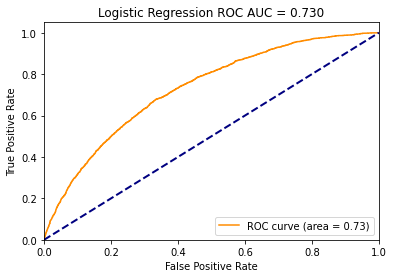

In [104]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

# Selection of parameters

In [105]:
parameters_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.linspace(1, 1000, num=5),
    'solver': ['sag', 'saga', 'lbfgs'],
    'l1_ratio': [0.25, 0.5, 0.75],
    'max_iter': np.arange(100, 500, 100)
}

lr = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(lr, parameters_grid,
                       scoring='roc_auc', cv=cv, verbose=2)

In [107]:
%%time
# we produce training on the grid
#grid_cv.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [ ]:
#print(grid_cv.best_score_)
#print(grid_cv.best_params_)

In [108]:
best_params = {'C': 500.5, 
               'l1_ratio': 0.25,
               'max_iter': 400, 
               'penalty': 'l2', 
               'solver': 'lbfgs'}

In [109]:
lr_gr = LogisticRegression(**best_params, class_weight='balanced')
lr_gr.fit(X_train, y_train)

y_pred_gr = lr_gr.predict(X_test)
y_score_gr = lr_gr.predict_proba(X_test)[:,1]

In [110]:
y_score_gr

array([0.38189562, 0.30253724, 0.52107507, ..., 0.61500845, 0.63855531,
       0.40706223])

In [111]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.729469967712985
precision: 0.23132313231323132
recall: 0.6581306017925737
f1: 0.34232434232434233
logloss: 11.091942941847053


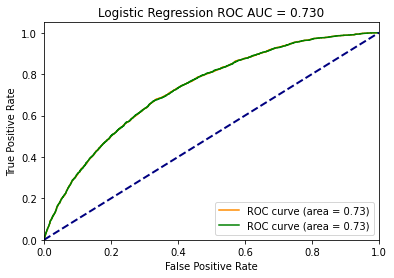

In [112]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_score_gr)

roc_auc_2 = auc(fpr_2, tpr_2)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_2, tpr_2, color='green', label='ROC curve (area = %0.2f)' % roc_auc_2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [113]:
metrics['Grid_LR'] = [roc_auc_score(y_test, y_score_gr),
                      precision_score(y_test, y_pred_gr),
                      recall_score(y_test, y_pred_gr),
                      f1_score(y_test, y_pred_gr),
                      log_loss(y_test, y_pred_gr)]

In [114]:
metrics

,Baseline_LR,Grid_LR
roc-auc,0.729500,0.729470
precision,0.231623,0.231323
recall,0.658984,0.658131
f1,0.342768,0.342324
logloss,11.084455,11.091943


In [120]:
lr_gr.coef_

array([[-0.00893296,  0.42664564,  1.0059267 ,  0.2815803 , -0.02581475,
        -0.0291934 , -0.09892391, -0.10693191,  0.17025007,  0.17025007,
         0.01719255, -0.18439912,  0.38743949,  0.27371252,  0.28996258,
         0.01140895, -0.30609449, -0.20584784,  0.59959537,  0.10669191,
         0.30925622,  0.4331676 , -0.23051265,  0.26107039,  0.17426055,
         0.43616362, -0.04217082, -0.08291535, -0.39856565]])

In [121]:
feature_imp = pd.DataFrame()
feature_imp['feature'] = X.columns
feature_imp['imp'] = lr_gr.coef_[0]
feature_imp = feature_imp.sort_values(by='imp', ascending=False)

In [122]:
feature_imp

,feature,imp
2,score_bki,1.005927
18,home_address_2,0.599595
25,sna_4,0.436164
21,work_address_3,0.433168
1,decline_app_cnt,0.426646
12,education_SCH,0.387439
20,work_address_2,0.309256
14,sex_M,0.289963
3,bki_request_cnt,0.281580
13,education_UGR,0.273713


In [123]:
df_label.groupby('default')[['score_bki']].median()

,score_bki
default,
0,-1.956982
1,-1.683857
